<a href="https://colab.research.google.com/github/bhuvana2004/Product-Outlet-Sales-Analysis-and-Prediction/blob/main/miniproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import numpy

filename = 'Test.csv'
raw_data = open(filename, 'rt')
reader = csv.reader(raw_data, delimiter=',', quoting=csv.QUOTE_NONE)

# Skip the header row
header = next(reader)

# Convert the remaining numeric data to a NumPy array
data = []
for row in reader:
    numeric_row = [float(value) for value in row if value.replace('.', '', 1).isdigit()]
    data.append(numeric_row)

# Convert the list of lists to a NumPy array
data = numpy.array(data)

print(data.shape)


(5681,)


<ipython-input-8-f495857fb3b3>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = numpy.array(data)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data.shape


(5681,)

In [ ]:
import pandas as pd
import numpy as np

df_encoded = pd.get_dummies(raw_data)
df_encoded.replace(0, np.nan, inplace=True)
df_imputed = df_encoded.fillna(df_encoded.mean())

TypeError: object of type '_io.TextIOWrapper' has no len()

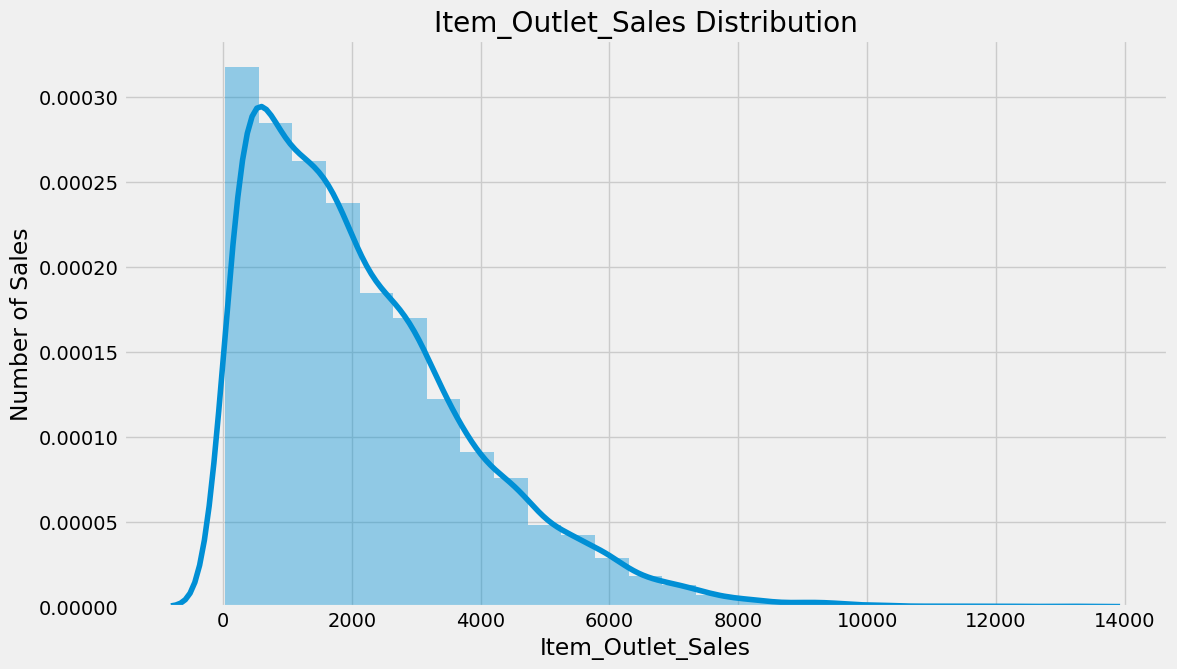

ValueError: could not convert string to float: 'Low Fat'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings  # Ignores any warning
warnings.filterwarnings("ignore")

train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
# print(train.head())
# train.info()
""" On seeing the data information, we see that there are many null values, thus we have to remove the 0 values
# Check for duplicates
idsUnique = len(set(train.Item_Identifier))
idsTotal = data.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")"""

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 7))
sns.distplot(train.Item_Outlet_Sales, bins=25)
plt.ticklabel_format(style='plain', axis='x', scilimits=(0, 1))
plt.xlabel("Item_Outlet_Sales")
plt.ylabel("Number of Sales")
plt.title("Item_Outlet_Sales Distribution")
plt.show()  # Distribution of item outlet sales

sns.countplot(train.Item_Fat_Content)
plt.show()  # Distribution of fat content

sns.countplot(train.Item_Type)
plt.xticks(rotation=90)
sns.countplot(train.Outlet_Size)
plt.show()  # Distribution of outlet size

sns.countplot(train.Outlet_Location_Type)
plt.show()  # Distribution of outlet location type

sns.countplot(train.Outlet_Type)
plt.xticks(rotation=90)
plt.show()  # Distribution of outlet type

# Join Train and Test Dataset

# Create source column to later separate the data easily
train['source'] = 'train'
test['source'] = 'test'

data = pd.concat([train, test], ignore_index=True)
print(train.shape, test.shape, data.shape)
# aggfunc is mean by default and ignores NaN by default

item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier')  # Create table with identifiers and its weights and ignores the NaN values


def impute_weight(cols):  # Filling null values with mean
    Weight = cols[0]
    Identifier = cols[1]

    if pd.isnull(Weight):
        return item_avg_weight['Item_Weight'][item_avg_weight.index == Identifier]
    else:
        return Weight


print ('Orignal missing: %d' % sum(data['Item_Weight'].isnull()))
print (data['Item_Weight'].mean())

data['Item_Weight'] = data[['Item_Weight', 'Item_Identifier']].apply(impute_weight, axis=1).astype(float)

print ('Final missing: %d' % sum(data['Item_Weight'].isnull()))

#print (data['Item_Weight'].mean())
from scipy.stats import mode

# Determing the mode for each
outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=lambda x: x.mode())


def impute_size_mode(cols):  # Same as above but using mode
    Size = cols[0]
    Type = cols[1]
    if pd.isnull(Size):
        return outlet_size_mode.loc['Outlet_Size'][outlet_size_mode.columns == Type][0]
    else:
        return Size


print ('Orignal missing: %d' % sum(data['Outlet_Size'].isnull()))
data['Outlet_Size'] = data[['Outlet_Size', 'Outlet_Type']].apply(impute_size_mode, axis=1)
print ('Final missing: %d' % sum(data['Outlet_Size'].isnull()))

visibility_item_avg = data.pivot_table(values='Item_Visibility', index='Item_Identifier')


def impute_visibility_mean(cols):
    visibility = cols[0]
    item = cols[1]
    if visibility == 0:
        return visibility_item_avg['Item_Visibility'][visibility_item_avg.index == item]
    else:
        return visibility


print ('Original zeros: %d' % sum(data['Item_Visibility'] == 0))
data['Item_Visibility'] = data[['Item_Visibility', 'Item_Identifier']].apply(impute_visibility_mean, axis=1).astype(float)

print ('Final zeros: %d' % sum(data['Item_Visibility'] == 0))
# Remember the data is from 2013
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

# Get the first two characters of ID:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])

# Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD': 'Food', 'NC': 'Non-Consumable', 'DR': 'Drinks'})

data['Item_Type_Combined'].value_counts()

data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF': 'Low Fat', 'reg': 'Regular',
                                                             'low fat': 'Low Fat'})

# print(data['Item_Fat_Content'].value_counts())

# Mark non-consumables as separate category in low_fat:

data.loc[data['Item_Type_Combined'] == "Non-Consumable", 'Item_Fat_Content'] = "Non-Edible"

data['Item_Fat_Content'].value_counts()


def func(x): return x['Item_Visibility'] / visibility_item_avg['Item_Visibility'][visibility_item_avg.index == x['Item_Identifier']][0]


data['Item_Visibility_MeanRatio'] = data.apply(func, axis=1).astype(float)
data['Item_Visibility_MeanRatio'].describe()


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# New variable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])

var_mod = ['Item_Fat_Content', 'Outlet_Location_Type', 'Outlet_Size', 'Item_Type_Combined', 'Outlet_Type', 'Outlet']

for i in var_mod:
    data[i] = le.fit_transform(data[i])

# Exporting the data back

# Drop the columns which have been converted to different types:
data.drop(['Item_Type', 'Outlet_Establishment_Year'], axis=1, inplace=True)

# Divide into test and train:
train = data.loc[data['source'] == "train"]
test = data.loc[data['source'] == "test"]

# Drop unnecessary columns:
test.drop(['Item_Outlet_Sales', 'source'], axis=1, inplace=True)
train.drop(['source'], axis=1, inplace=True)

# Export files as modified versions:
train.to_csv("data/train_modified.csv", index=False)
test.to_csv("data/test_modified.csv", index=False)

train_df = pd.read_csv('data/train_modified.csv')
test_df = pd.read_csv('data/test_modified.csv')

# Define target and ID columns:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier', 'Outlet_Identifier']

from sklearn import cross_validation
from sklearn import metrics


def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    # Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])

    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    # Remember the target had been normalized
    Sq_train = (dtrain[target])**2

# Perform cross-validation:
    cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], Sq_train, cv=20, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))

    # Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(Sq_train.values, dtrain_predictions)))

    print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))

    # Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])

    # Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({x: dtest[x] for x in IDcol})
    submission.to_csv(filename, index=False)


# Linear Regression model
from sklearn.linear_model import LinearRegression
LR = LinearRegression(normalize=True)

predictors = train_df.columns.drop(['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier'])
modelfit(LR, train_df, test_df, predictors, target, IDcol, 'LR.csv')
# Decision Tree model
from sklearn.tree import DecisionTreeRegressor
DT = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(DT, train_df, test_df, predictors, target, IDcol, "DT.csv")

RF = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)
modelfit(RF, train_df, test_df, predictors, target, IDcol, "RF.csv")

In [ ]:
df_train = pd.read_csv("Train.csv")
df_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
print("Columns in training dataset based on datatypes {}".format(df_train.columns.to_series().groupby(df_train.dtypes).groups))


Columns in training dataset based on datatypes {int64: ['Outlet_Establishment_Year'], float64: ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales'], object: ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']}


In [ ]:
df_train.shape


(8523, 12)

In [ ]:
df_train.isnull().sum()


Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

<Axes: >

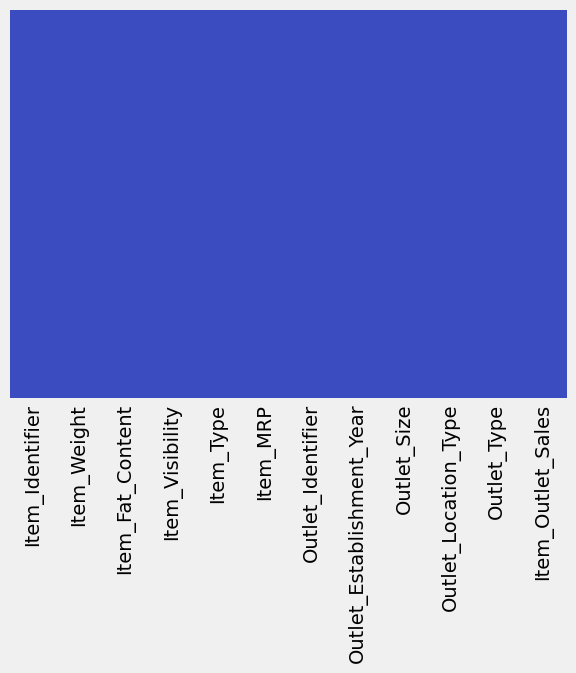

In [ ]:
df_train['Item_Weight']=df_train['Item_Weight'].fillna(df_train['Item_Weight'].mean())
df_train['Outlet_Size']=df_train['Outlet_Size'].fillna(df_train['Outlet_Size'].mode()[0])
import seaborn as sns
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='coolwarm')

In [ ]:
df_train.describe(include = 'all')


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,8523,8523.000000,8523,8523.000000,8523,8523.000000,8523,8523.000000,8523,8523,8523,8523.000000
unique,1559,NaN,5,NaN,16,NaN,10,NaN,3,3,4,NaN
top,FDW13,NaN,Low Fat,NaN,Fruits and Vegetables,NaN,OUT027,NaN,Medium,Tier 3,Supermarket Type1,NaN
freq,10,NaN,5089,NaN,1232,NaN,935,NaN,5203,3350,5577,NaN
mean,NaN,12.857645,NaN,0.066132,NaN,140.992782,NaN,1997.831867,NaN,NaN,NaN,2181.288914
std,NaN,4.226124,NaN,0.051598,NaN,62.275067,NaN,8.371760,NaN,NaN,NaN,1706.499616
min,NaN,4.555000,NaN,0.000000,NaN,31.290000,NaN,1985.000000,NaN,NaN,NaN,33.290000
25%,NaN,9.310000,NaN,0.026989,NaN,93.826500,NaN,1987.000000,NaN,NaN,NaN,834.247400
50%,NaN,12.857645,NaN,0.053931,NaN,143.012800,NaN,1999.000000,NaN,NaN,NaN,1794.331000
75%,NaN,16.000000,NaN,0.094585,NaN,185.643700,NaN,2004.000000,NaN,NaN,NaN,3101.296400


In [ ]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


<Axes: >

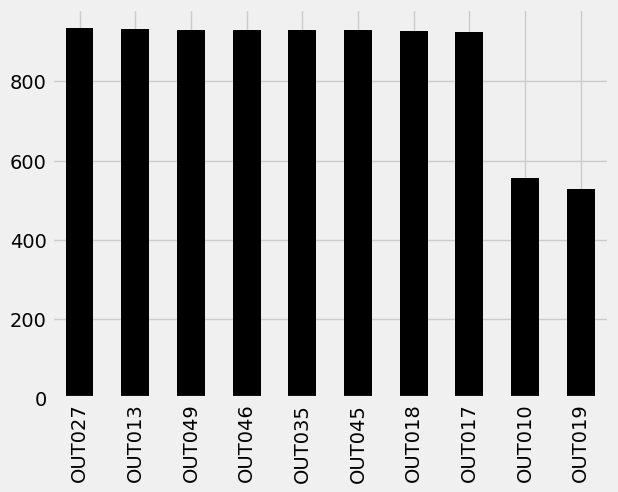

In [ ]:
df_train['Outlet_Identifier'].value_counts().plot(kind='bar',color = 'Black')


In [ ]:
df_train = df_train.drop(['Item_Identifier','Outlet_Identifier'],axis=1)
df_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,1998,Medium,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052


<Axes: >

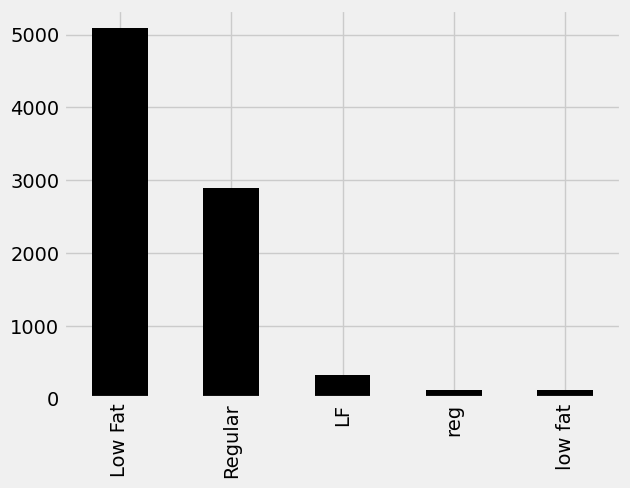

In [ ]:
df_train['Item_Fat_Content'].value_counts().plot(kind='bar',color = 'black')

<Axes: >

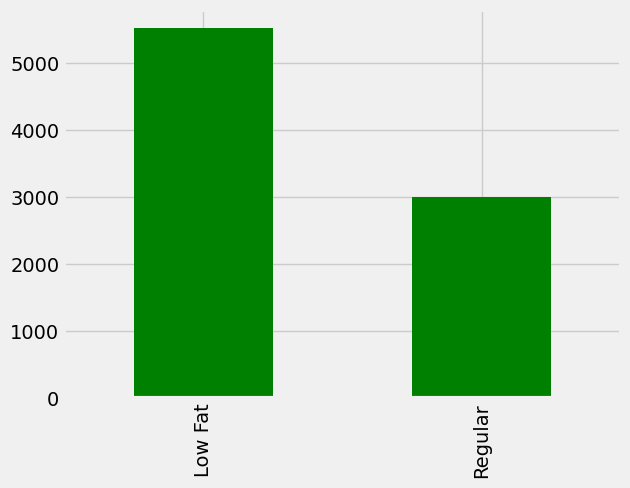

In [ ]:
df_train =  df_train.replace(to_replace ="low fat",  value ="Low Fat")
df_train =  df_train.replace(to_replace ="LF",  value ="Low Fat")
df_train =  df_train.replace(to_replace ="reg",  value ="Regular")
df_train['Item_Fat_Content'].value_counts().plot(kind='bar',color = 'Green')

<Axes: >

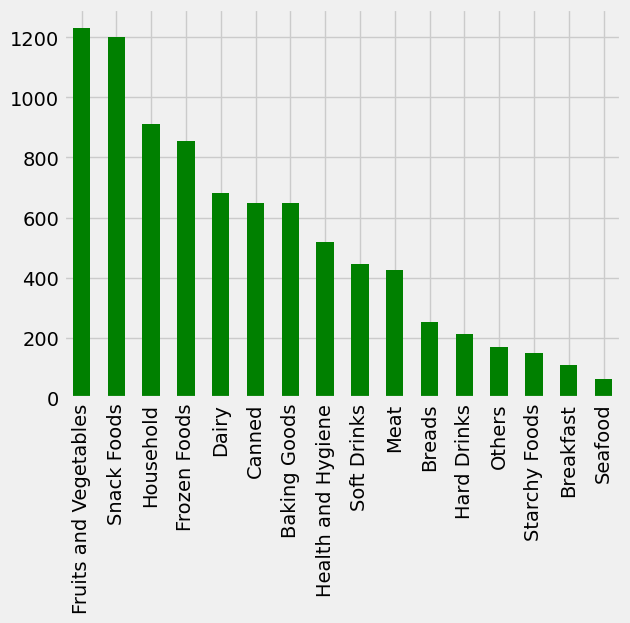

In [ ]:
df_train['Item_Type'].value_counts().plot(kind='bar',color = 'Green')

<Axes: >

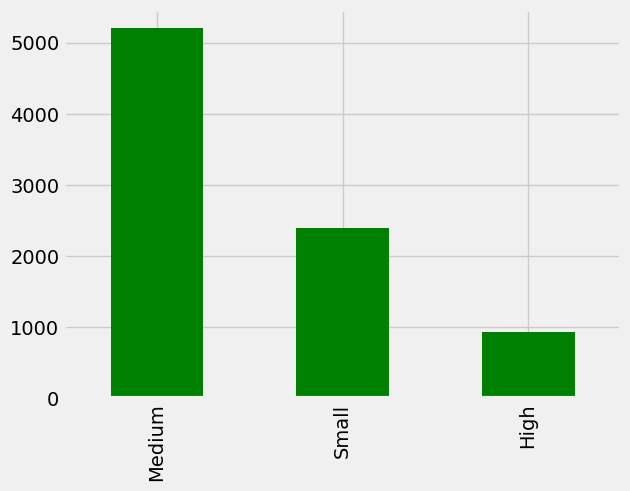

In [ ]:
df_train['Outlet_Size'].value_counts().plot(kind='bar',color = 'green')

<Axes: >

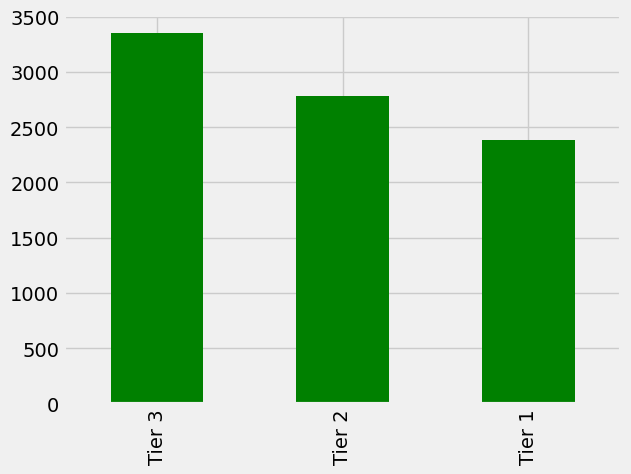

In [ ]:
df_train['Outlet_Location_Type'].value_counts().plot(kind='bar',color = 'Green')

<Axes: >

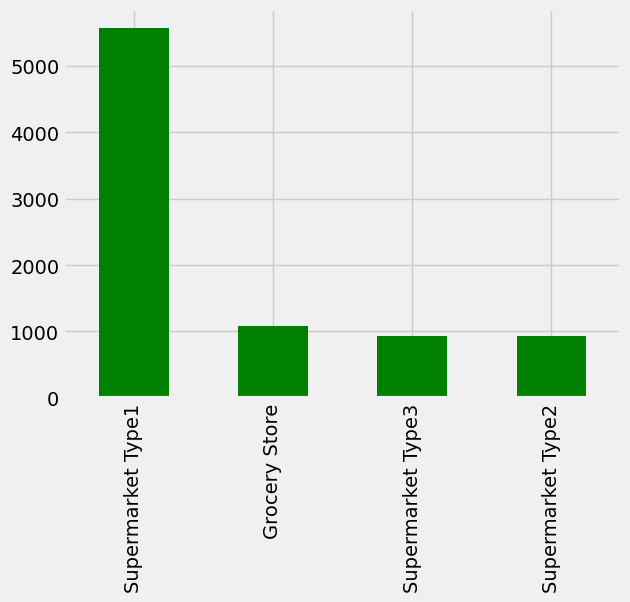

In [ ]:
df_train['Outlet_Type'].value_counts().plot(kind='bar',color = 'green')

<Axes: xlabel='Item_Weight', ylabel='Density'>

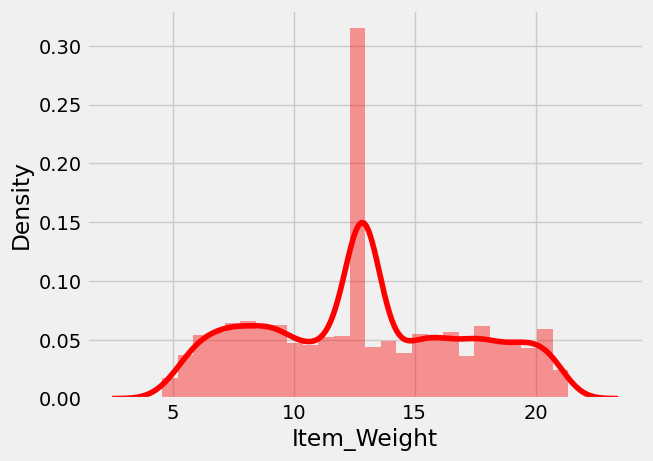

In [ ]:
y = df_train['Item_Weight']
plt.figure(1);
sns.distplot(y, kde=True,color = 'red')

<Axes: xlabel='Item_Visibility', ylabel='Density'>

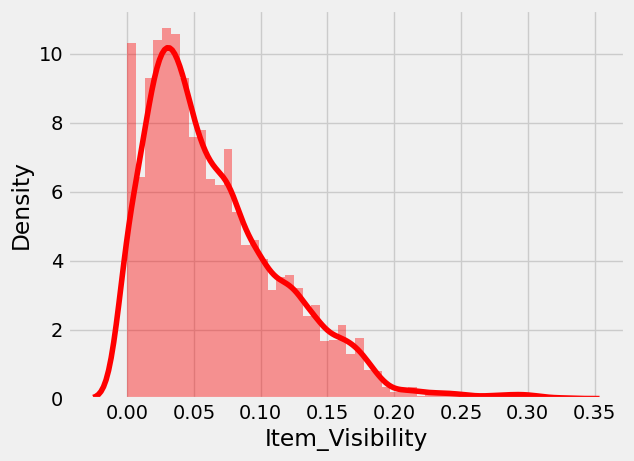

In [ ]:
y = df_train['Item_Visibility']
plt.figure(1);
sns.distplot(y, kde=True,color = 'red')

<Axes: xlabel='Item_MRP', ylabel='Density'>

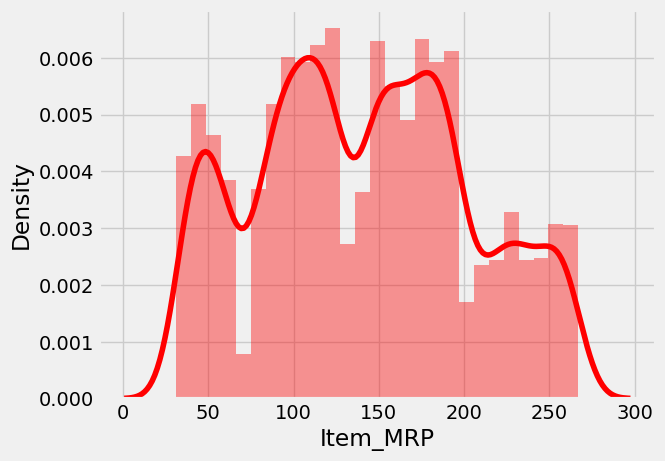

In [ ]:
y = df_train['Item_MRP']
plt.figure(1);
sns.distplot(y, kde=True,color = 'red')

<Axes: xlabel='Outlet_Establishment_Year', ylabel='Density'>

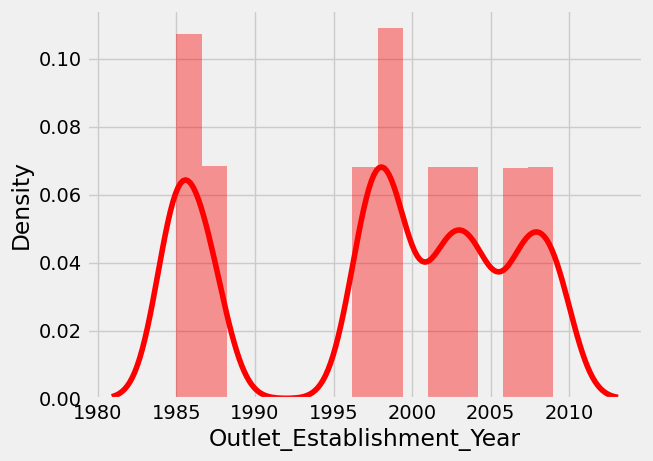

In [ ]:
y = df_train['Outlet_Establishment_Year']
plt.figure(1);
sns.distplot(y, kde=True,color = 'red')

<Axes: xlabel='Item_Outlet_Sales', ylabel='Density'>

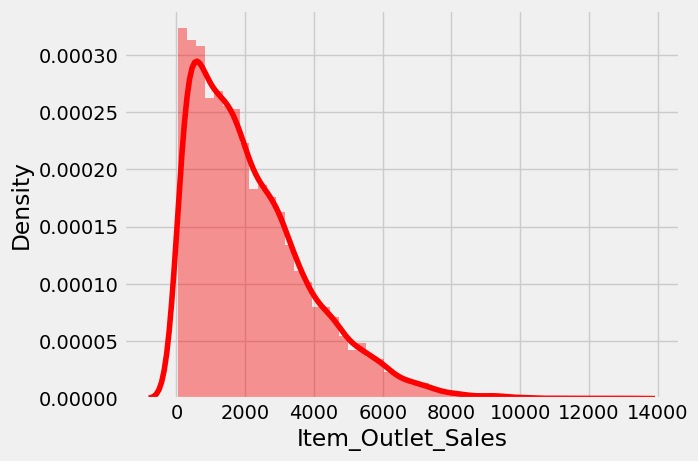

In [ ]:
y = df_train['Item_Outlet_Sales']
plt.figure(1);
sns.distplot(y, kde=True,color = 'red')

In [ ]:
df_train["Qty_Sold"] = (df_train["Item_Outlet_Sales"]/df_train["Item_MRP"])
df_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Qty_Sold
0,9.30,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380,14.951963
1,5.92,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228,9.186454
2,17.50,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700,14.809346
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,1998,Medium,Tier 3,Grocery Store,732.3800,4.021967
4,8.93,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052,18.467868


<Axes: >

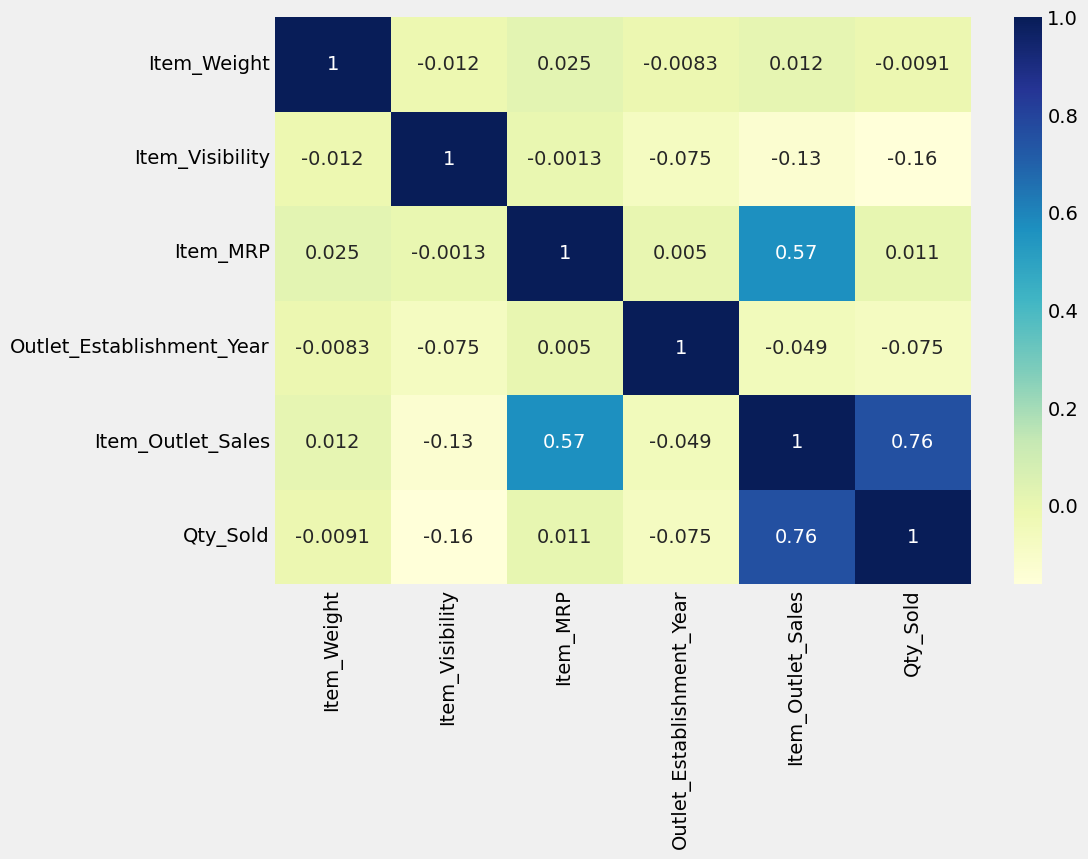

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
sns.heatmap(df_train.corr(),annot=True,cmap="YlGnBu")

In [ ]:
categorical_columns=[x for x in df_train.dtypes.index if df_train.dtypes[x]=='object']
categorical_columns

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [ ]:
df_train.pivot_table(index='Outlet_Type',values='Item_Outlet_Sales')

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


In [ ]:
#print frequencies of these categories
for col in categorical_columns:
    print('Frequency of categories for variable')
    print(df_train[col].value_counts())
    print("\n")

Frequency of categories for variable
Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64


Frequency of categories for variable
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Frequency of categories for variable
Medium    5203
Small     2388
High       932
Name: Outlet_Size, dtype: int64


Frequency of categories for variable
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64


Frequency of categories for variable
Supermarket Type1    5577
Grocery Store        1083
Supermarket T

In [ ]:
#Encoding Categorical Variables
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
for col in df_train.columns:
    df_train[col] = labelencoder.fit_transform(df_train[col])

In [ ]:
#Now one hot encoding
df_train=pd.get_dummies(df_train, columns=['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type'],drop_first=False)

print(df_train.shape)

(8523, 34)


In [ ]:
df_train.columns

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales', 'Qty_Sold',
       'Item_Fat_Content_0', 'Item_Fat_Content_1', 'Item_Type_0',
       'Item_Type_1', 'Item_Type_2', 'Item_Type_3', 'Item_Type_4',
       'Item_Type_5', 'Item_Type_6', 'Item_Type_7', 'Item_Type_8',
       'Item_Type_9', 'Item_Type_10', 'Item_Type_11', 'Item_Type_12',
       'Item_Type_13', 'Item_Type_14', 'Item_Type_15', 'Outlet_Size_0',
       'Outlet_Size_1', 'Outlet_Size_2', 'Outlet_Location_Type_0',
       'Outlet_Location_Type_1', 'Outlet_Location_Type_2', 'Outlet_Type_0',
       'Outlet_Type_1', 'Outlet_Type_2', 'Outlet_Type_3'],
      dtype='object')

In [ ]:
#Rearrangement of the columns......

df = df_train[['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year',
       'Item_Fat_Content_0', 'Item_Fat_Content_1', 'Item_Type_0',
       'Item_Type_1', 'Item_Type_2', 'Item_Type_3', 'Item_Type_4',
       'Item_Type_5', 'Item_Type_6', 'Item_Type_7', 'Item_Type_8',
       'Item_Type_9', 'Item_Type_10', 'Item_Type_11', 'Item_Type_12',
       'Item_Type_13', 'Item_Type_14', 'Item_Type_15', 'Outlet_Size_0',
       'Outlet_Size_1', 'Outlet_Size_2', 'Outlet_Location_Type_0',
       'Outlet_Location_Type_1', 'Outlet_Location_Type_2', 'Outlet_Type_0',
       'Outlet_Type_1', 'Outlet_Type_2', 'Outlet_Type_3', 'Item_Outlet_Sales', 'Qty_Sold']]
df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_0,Item_Fat_Content_1,Item_Type_0,Item_Type_1,Item_Type_2,Item_Type_3,...,Outlet_Size_2,Outlet_Location_Type_0,Outlet_Location_Type_1,Outlet_Location_Type_2,Outlet_Type_0,Outlet_Type_1,Outlet_Type_2,Outlet_Type_3,Item_Outlet_Sales,Qty_Sold
0,284,664,5592,4,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,2540,4084
1,57,880,473,8,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,422,2217
2,376,715,2901,4,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1639,3972
3,393,0,4227,3,0,1,0,0,0,0,...,0,0,0,1,1,0,0,0,670,1119
4,265,0,627,1,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,865,5315


In [ ]:
df.shape


(8523, 34)

In [ ]:
for col in df.columns:
    print(col)

Item_Weight
Item_Visibility
Item_MRP
Outlet_Establishment_Year
Item_Fat_Content_0
Item_Fat_Content_1
Item_Type_0
Item_Type_1
Item_Type_2
Item_Type_3
Item_Type_4
Item_Type_5
Item_Type_6
Item_Type_7
Item_Type_8
Item_Type_9
Item_Type_10
Item_Type_11
Item_Type_12
Item_Type_13
Item_Type_14
Item_Type_15
Outlet_Size_0
Outlet_Size_1
Outlet_Size_2
Outlet_Location_Type_0
Outlet_Location_Type_1
Outlet_Location_Type_2
Outlet_Type_0
Outlet_Type_1
Outlet_Type_2
Outlet_Type_3
Item_Outlet_Sales
Qty_Sold


In [ ]:
#Separating features and label
X = df.iloc[:,0:33].values
y = df.iloc[:,-1].values


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)

In [ ]:
# Applying PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = None)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

print(explained_variance)

In [ ]:
len(explained_variance)

33

In [ ]:
print("Sorted List returned :")
print(sorted(explained_variance,reverse = True))

Sorted List returned :
[0.6103942302780854, 0.3357370634408003, 0.05289630513664155, 0.0009712998481694148, 8.057152404511474e-07, 6.863376274915171e-08, 5.014850813766624e-08, 2.858644446155589e-08, 2.5897644122210764e-08, 1.903876098556518e-08, 1.506036083130962e-08, 1.2925730268760926e-08, 1.0397672985759154e-08, 9.651459329541203e-09, 8.331018856622041e-09, 8.094676689747245e-09, 6.723919893576689e-09, 6.415058079298107e-09, 5.747254534657664e-09, 5.1042420871578e-09, 3.355102078823466e-09, 2.7230464604746854e-09, 2.258000420755252e-09, 1.959470547859085e-09, 1.6507596848019621e-09, 1.402244346284231e-09, 8.963738320443836e-10, 5.79551476265241e-10, 3.9459342597126464e-33, 3.9459342597126464e-33, 3.9459342597126464e-33, 3.9459342597126464e-33, 3.9459342597126464e-33]


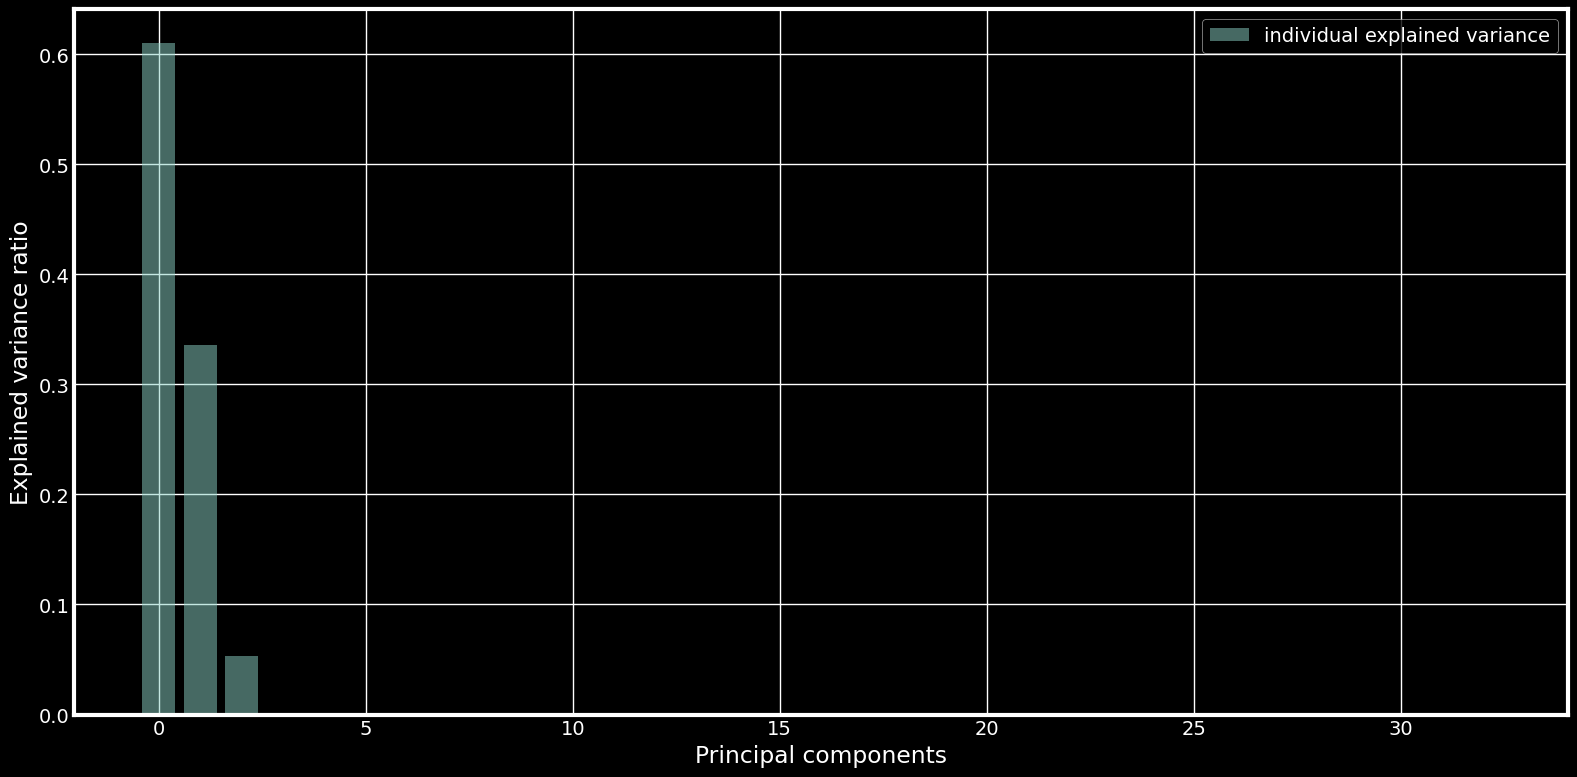

In [ ]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(16, 8))

    plt.bar(range(33), explained_variance, alpha=0.5, align='center',label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[0.61039423 0.33573706 0.05289631]


In [ ]:
#Model comparison
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import AdaBoostRegressor,BaggingRegressor,ExtraTreesRegressor,GradientBoostingRegressor

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [ ]:
forest = RandomForestRegressor(n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [ ]:
Ada_boost = AdaBoostRegressor()
Ada_boost.fit(X_train, y_train)

AdaBoostRegressor()

In [ ]:
Bagging = BaggingRegressor()
Bagging.fit(X_train, y_train)

BaggingRegressor()

In [ ]:
Extra_trees = ExtraTreesRegressor()
Extra_trees.fit(X_train, y_train)

ExtraTreesRegressor()

In [ ]:
Gradient_boosting = GradientBoostingRegressor()
Gradient_boosting.fit(X_train, y_train)

GradientBoostingRegressor()

In [ ]:
models= [('lin_reg', lin_reg), ('forest', forest), ('dt', tree),('Ada_boost',Ada_boost),('Bagging',Bagging),('Extra_trees',Extra_trees),('Gradient_boosting',Gradient_boosting)]
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
results= []
metric= []
for name, model in models:
    for i in scoring:
        scores = cross_validate(model, X_train, y_train, scoring=i, cv=10, return_train_score=True)
        results.append(scores)

print(results[20])

{'fit_time': array([0.78087306, 0.778193  , 0.78639436, 0.80026031, 0.77730322,
       0.78964806, 0.78826547, 0.7938807 , 0.7955792 , 0.79789948]), 'score_time': array([0.00208902, 0.00215816, 0.00213504, 0.0020926 , 0.00207424,
       0.00242734, 0.00214791, 0.00213504, 0.00209117, 0.00206733]), 'test_score': array([0.99434539, 0.99387038, 0.99241757, 0.99364933, 0.99285346,
       0.99384747, 0.99304793, 0.99363296, 0.9937016 , 0.99263827]), 'train_score': array([0.99515365, 0.99489962, 0.99461739, 0.99476625, 0.99451677,
       0.99489476, 0.99478788, 0.99512551, 0.99481143, 0.99462345])}


In [ ]:
LR_RMSE_mean = np.sqrt(-results[0]['test_score'].mean())
LR_RMSE_std= results[0]['test_score'].std()
# note that also here I changed the sign, as the result is originally a negative number for ease of computation
LR_MAE_mean = -results[1]['test_score'].mean()
LR_MAE_std= results[1]['test_score'].std()
LR_r2_mean = results[2]['test_score'].mean()
LR_r2_std = results[2]['test_score'].std()


In [ ]:
RF_RMSE_mean = np.sqrt(-results[3]['test_score'].mean())
RF_RMSE_std= results[3]['test_score'].std()
RF_MAE_mean = -results[4]['test_score'].mean()
RF_MAE_std= results[4]['test_score'].std()
RF_r2_mean = results[5]['test_score'].mean()
RF_r2_std = results[5]['test_score'].std()

In [ ]:
DT_RMSE_mean = np.sqrt(-results[6]['test_score'].mean())
DT_RMSE_std= results[6]['test_score'].std()
DT_MAE_mean = -results[7]['test_score'].mean()
DT_MAE_std= results[7]['test_score'].std()
DT_r2_mean = results[8]['test_score'].mean()
DT_r2_std = results[8]['test_score'].std()


In [ ]:
ADA_RMSE_mean = np.sqrt(-results[9]['test_score'].mean())
ADA_RMSE_std= results[9]['test_score'].std()
# note that also here I changed the sign, as the result is originally a negative number for ease of computation
ADA_MAE_mean = -results[10]['test_score'].mean()
ADA_MAE_std= results[10]['test_score'].std()
ADA_r2_mean = results[11]['test_score'].mean()
ADA_r2_std = results[11]['test_score'].std()

In [ ]:
BAGGING_RMSE_mean = np.sqrt(-results[12]['test_score'].mean())
BAGGING_RMSE_std= results[12]['test_score'].std()
# note that also here I changed the sign, as the result is originally a negative number for ease of computation
BAGGING_MAE_mean = -results[13]['test_score'].mean()
BAGGING_MAE_std= results[13]['test_score'].std()
BAGGING_r2_mean = results[14]['test_score'].mean()
BAGGING_r2_std = results[14]['test_score'].std()

In [ ]:
ET_RMSE_mean = np.sqrt(-results[15]['test_score'].mean())
ET_RMSE_std= results[15]['test_score'].std()
# note that also here I changed the sign, as the result is originally a negative number for ease of computation
ET_MAE_mean = -results[16]['test_score'].mean()
ET_MAE_std= results[16]['test_score'].std()
ET_r2_mean = results[17]['test_score'].mean()
ET_r2_std = results[17]['test_score'].std()

In [ ]:
GB_RMSE_mean = np.sqrt(-results[18]['test_score'].mean())
GB_RMSE_std= results[18]['test_score'].std()
# note that also here I changed the sign, as the result is originally a negative number for ease of computation
GB_MAE_mean = -results[19]['test_score'].mean()
GB_MAE_std= results[19]['test_score'].std()
GB_r2_mean = results[20]['test_score'].mean()
GB_r2_std = results[20]['test_score'].std()

In [ ]:
modelDF = pd.DataFrame({
    'Model'       : ['Linear Regression', 'Random Forest', 'Decision Trees','Ada Boosting','Bagging','Extra trees','Gradient Boosting'],
    'RMSE_mean'    : [LR_RMSE_mean, RF_RMSE_mean, DT_RMSE_mean,ADA_RMSE_mean,BAGGING_RMSE_mean,ET_RMSE_mean,GB_RMSE_mean],
    'RMSE_std'    : [LR_RMSE_std, RF_RMSE_std, DT_RMSE_std,ADA_RMSE_std,BAGGING_RMSE_std,ET_RMSE_std,GB_RMSE_std],
    'MAE_mean'   : [LR_MAE_mean, RF_MAE_mean, DT_MAE_mean,ADA_MAE_mean,BAGGING_MAE_mean,ET_MAE_mean,GB_MAE_mean],
    'MAE_std'   : [LR_MAE_std, RF_MAE_std, DT_MAE_std, ADA_MAE_std, BAGGING_MAE_std, ET_MAE_std, GB_MAE_std],
    'r2_mean'      : [LR_r2_mean, RF_r2_mean, DT_r2_mean, ADA_r2_mean,BAGGING_r2_mean, ET_r2_mean, GB_r2_mean],
    'r2_std'      : [LR_r2_std, RF_r2_std, DT_r2_std, ADA_r2_std,BAGGING_r2_std, ET_r2_std, GB_r2_std],
    }, columns = ['Model', 'RMSE_mean', 'RMSE_std', 'MAE_mean', 'MAE_std', 'r2_mean', 'r2_std'])


modelDF.sort_values(by='r2_mean', ascending=False)

,Model,RMSE_mean,RMSE_std,MAE_mean,MAE_std,r2_mean,r2_std
5,Extra trees,101.931229,712.151013,72.651663,1.980595,0.998085,0.000176
1,Random Forest,109.868791,693.644494,80.318727,1.950505,0.997851,0.000164
4,Bagging,124.183059,1188.778561,91.789155,2.555045,0.997328,0.000216
2,Decision Trees,187.352304,2330.631329,133.331974,3.775653,0.993677,0.000497
6,Gradient Boosting,190.815362,3257.347301,144.435919,6.300198,0.993400,0.000591
3,Ada Boosting,466.550722,13187.866450,385.188259,15.268958,0.960643,0.003337
0,Linear Regression,751.266385,28450.046795,543.986537,12.821990,0.897669,0.005637


AttributeError: Rectangle.set() got an unexpected keyword argument 'size'

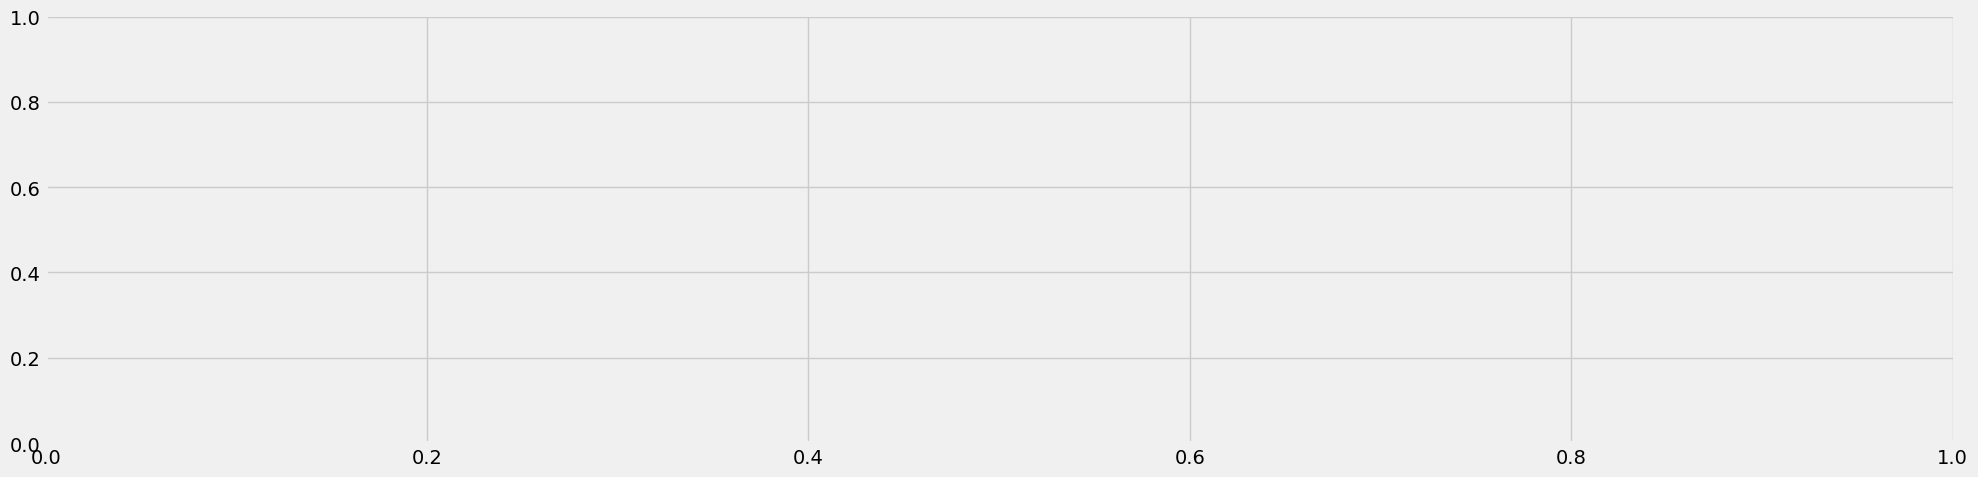

In [ ]:
import seaborn as sns

sns.catplot(x= 'Model', y= 'RMSE_mean', data= modelDF, kind='bar',size=6, aspect=4)

In [ ]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold

ETC = ExtraTreesRegressor()
gb_param_grid = {'n_estimators' : [100,200,300,400,500],
              'max_depth': [4, 8,12,16],
              'min_samples_leaf' : [100,150,200,250],
              'max_features' : [0.3, 0.1]
              }

gsETC = GridSearchCV(ETC,param_grid = gb_param_grid, cv=10, n_jobs= -1, verbose = 0)

gsETC.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=ExtraTreesRegressor(), n_jobs=-1,
             param_grid={'max_depth': [4, 8, 12, 16],
                         'max_features': [0.3, 0.1],
                         'min_samples_leaf': [100, 150, 200, 250],
                         'n_estimators': [100, 200, 300, 400, 500]})

In [ ]:
ETC_best = gsETC.best_estimator_


In [ ]:
gsETC.best_score_,gsETC.best_params_

(0.5292065576638437,
 {'max_depth': 16,
  'max_features': 0.1,
  'min_samples_leaf': 100,
  'n_estimators': 100})

In [ ]:

ETC = ExtraTreesRegressor(max_depth= 8,max_features = 0.3,min_samples_leaf =  100,n_estimators= 500)
ETC.fit(X_train, y_train)


#predicting the test set
y_pred = ETC.predict(X_test)

In [ ]:
from sklearn import metrics
print("MAE:", metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 1361.8494593234202
MSE: 2475722.122442946
RMSE: 1573.4427610952189
